---

# Neural Network

https://wvs.earthdata.nasa.gov/?LAYERS=MODIS_Terra_CorrectedReflectance_TrueColor&CRS=EPSG:4326&TIME=2000-03-01&COORDINATES=47.000000,5.000000,55.000000,15.000000&FORMAT=image/jpeg&AUTOSCALE=TRUE&RESOLUTION=10km

In [1]:
import glob
import sys

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io
import xarray as xr
import os
from  sklearn.neural_network  import  MLPRegressor

import utils

Open one sample file:

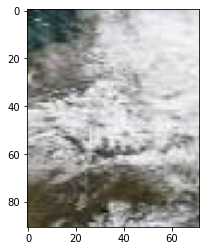

In [2]:
path = os.getcwd()
path_sat_ger = path + "/sat_ger_2010to2020"

img = mpimg.imread(path_sat_ger + '/sat_ger_2010-03-01.jpg')
imgplot = plt.imshow(img)
plt.show()

Read all Satellite Images:

In [3]:
imgs = utils.read_satellite_images_ger(str(path_sat_ger + "/sat_ger_201*"))

reading 3652 images...
Summary:
   Could not open 1 files (=0.027%)
   17 (=0.465%) images had a weird shape and were skipped


Read Daily Munich Station Pressure and deseasonalize:

In [4]:
# read data
muc = utils.munich_station_daily(location=path, to_xarray=True)

# select pressure and remove invalid data
pvalid = muc.pressure.where(muc.pressure != -999.0).dropna("time")

# compute anomalies
panom = pvalid.groupby("time.dayofyear") - pvalid.groupby("time.dayofyear").mean()

Merge Both DataArrays to one Dataset with time as the last dimension:

In [5]:
merged = xr.merge([panom, imgs], join="inner")
merged

<xarray.Dataset>
Dimensions:    (rgb: 3, time: 3632, x: 91, y: 72)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2019-12-31
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
  * x          (x) int32 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89 90
  * y          (y) int32 0 1 2 3 4 5 6 7 8 9 ... 62 63 64 65 66 67 68 69 70 71
  * rgb        (rgb) <U1 'r' 'g' 'b'
Data variables:
    pressure   (time) float64 -23.04 -3.118 0.3451 -3.611 ... 17.67 13.8 13.38
    imgs       (time, x, y, rgb) uint8 220 220 230 166 166 ... 60 55 45 46 41

Turn Xarray to NumPy array

In [6]:
X_raw = merged.imgs.stack(feature =["x", "y", "rgb"]).values
y = merged.pressure.values

# normalize input data to mean = 0 and std = 1

X = (X_raw  - X_raw.mean(axis =0)) / X_raw.std(axis =0)

Split into Training and Test Data

In [7]:
x_train = X[:int(X.shape[0]/2), :]
y_train = y[:int(X.shape[0]/2)]
x_test = X[int(X.shape[0]/2):, :]
y_test = y[int(X.shape[0]/2):]

In [8]:
#create a multi linear problem regressor model and train it

model = MLPRegressor(hidden_layer_sizes = 15,  activation = 'relu')
model.fit(x_train, y_train)

MLPRegressor(hidden_layer_sizes=15)

In [9]:
#use the model to predict

y_predict = model.predict(x_test)

Correlation between training and real pressure anomalies: 0.9611775660179211


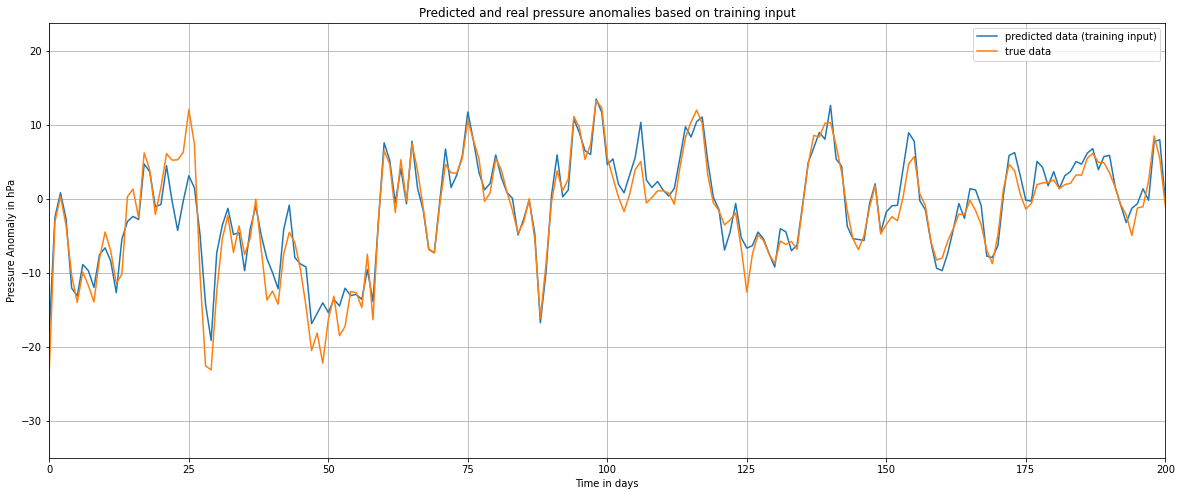

In [10]:
#plot the training data and compute the correlation

y_predict_train = model.predict(x_train)

print('Correlation between training and real pressure anomalies:\f', np.corrcoef(np.stack((y_predict_train, y_train)))[0,1])
plt.figure(figsize = (20,8))
plt.plot(np.arange(len(y_test)), y_predict_train, label = 'predicted data (training input)')
plt.plot(np.arange(len(y_test)), y_train, label = 'true data')
#plt.plot(np.arange(len(y_train)), (y_train - y_predict_train), label = 'difference')
plt.xlabel('Time in days')
plt.ylabel('Pressure Anomaly in hPa')
plt.xlim(0,200)
plt.legend()
plt.grid()
plt.title('Predicted and real pressure anomalies based on training input')
plt.show()

Correlation between predicted and real pressure anomalies: 0.48664632463035784


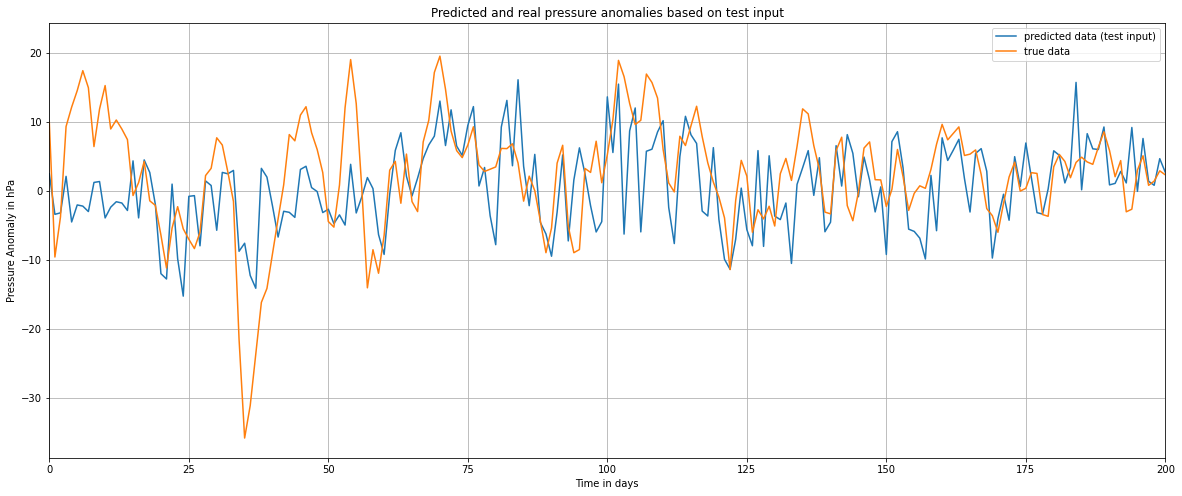

In [11]:
#plot the test data and compute the correlation

print('Correlation between predicted and real pressure anomalies:\f', np.corrcoef(np.stack((y_predict, y_test)))[0,1])
plt.figure(figsize = (20,8))
plt.plot(np.arange(len(y_test)), y_predict, label = 'predicted data (test input)')
plt.plot(np.arange(len(y_test)), y_test, label = 'true data')
#plt.plot(np.arange(len(y_test)), (y_test - y_predict), label = 'difference')
plt.xlabel('Time in days')
plt.ylabel('Pressure Anomaly in hPa')
plt.xlim(0,200)
plt.legend()
plt.grid()
plt.title('Predicted and real pressure anomalies based on test input')
plt.show()

---

# k-Means

In [12]:
data = utils.munich_berlin_sylt_station_yearly(path + "/dwd_yearly")

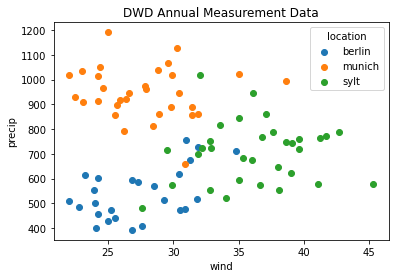

In [13]:
variables = ["wind", "precip"]

data.plot.scatter(x=variables[0], y=variables[1], hue="location")
plt.title("DWD Annual Measurement Data")
plt.show()

**k-Means**

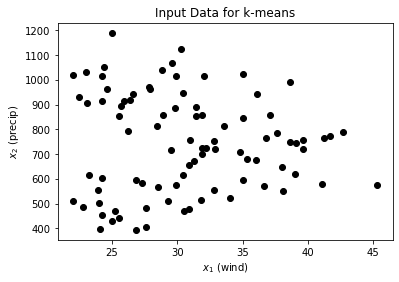

In [14]:
data_stacked = data[variables].stack(datapoint=["time", "location"]).dropna("datapoint")
X_raw = np.stack([data_stacked[var] for var in variables], axis=1)
Y = data_stacked.location.values

plt.scatter(*X_raw.T, color="k")
plt.xlabel("$x_1$ ({})".format(variables[0]))
plt.ylabel("$x_2$ ({})".format(variables[1]))
plt.title("Input Data for k-means")
plt.show()

In [15]:
from sklearn.cluster import KMeans

X = (X_raw - X_raw.mean(axis=0)) / X_raw.std(axis=0)

kmeans = KMeans(n_clusters = 3).fit(X)

In [16]:
kmeans.cluster_centers_

array([[ 1.06881922, -0.10706427],
       [-0.64156799, -1.1180827 ],
       [-0.58404824,  1.08320689]])

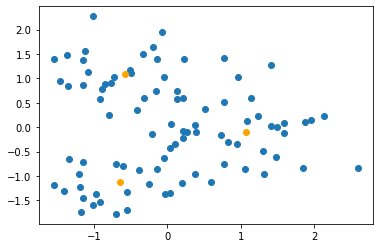

In [17]:
plt.scatter(*X.T)
plt.scatter(*kmeans.cluster_centers_.T, color = 'orange')
plt.show()

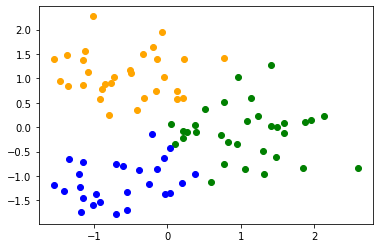

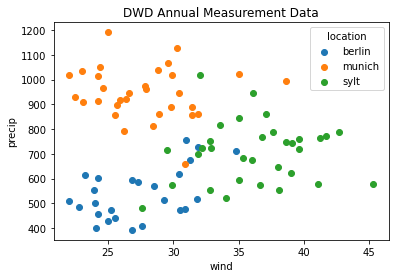

In [19]:
fig, ax = plt.subplots()

for i in X:
    min_dis = 100
    for j in kmeans.cluster_centers_:
        if(np.sqrt((i[0]-j[0])**2+(i[1]-j[1])**2) < min_dis):
            min_dis = np.sqrt((i[0]-j[0])**2+(i[1]-j[1])**2)
            cluster = j
    if(cluster[0] == kmeans.cluster_centers_[0,0]):
        ax.scatter(*i, color = 'g')
    if(cluster[0] == kmeans.cluster_centers_[1,0]):
        ax.scatter(*i, color = 'b')
    if(cluster[0] == kmeans.cluster_centers_[2,0]):
        ax.scatter(*i, color = 'orange')
plt.show()

data.plot.scatter(x=variables[0], y=variables[1], hue="location")
plt.title("DWD Annual Measurement Data")
plt.show()